# pickle load the catalog 

of physical parameters for objects in the 3D-HST survey

In [3]:
import sys, os, pickle
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import prospect
from astropy.io import fits
from sedpy import observate

In [4]:
noise_free = pickle.load(open('noise_free_model.pickle', 'rb'))

# add noise

In [11]:
    filters = ['bessell_U']
    filters +=  ['sdss_'+filt+'0' for filt in ['g','r','i','z']]
    filters += ['uvista_y_cosmos','UDS_J']
    filters += ['IRAC_CH1','IRAC_CH2']
    phot_snr = 20
    
    hdu = fits.open('../input/noise_spec_12hr.fits')
    wave_obs = hdu[1].data['WAV']
    #detector_noise = hdu[1].data['ERR']/1e-23/3631 * wave_obs**2/(3e18) # erg/s/cm^2/A
    # > this should be the 'NOISE' column
    # > why are we converting it?
    detector_noise = hdu[1].data['NOISE'] /(1e-23)/3631 * wave_obs**2/(3e18) # erg/s/cm^2/A
    detector_noise_err = hdu[1].data['ERR'] /(1e-23)/3631 * wave_obs**2/(3e18) # erg/s/cm^2/A

    ### Remove repeated wavelength values
    print('REMOVING REPEATED WAVELENGTH VALUES')
    _, idx = np.unique(wave_obs, return_index=True)
    wave_obs = wave_obs[idx]
    detector_noise = detector_noise[idx]
    detector_noise_err = detector_noise_err[idx]

    ### define masks
    mask = np.ones(len(wave_obs),dtype=bool)
    phot_mask = np.ones(len(filters),dtype='bool')

    ### load up photometry
    obs = {'filters':  []}
    # --- remember to define redshift later! #
    for filt in filters:
        print('loading '+filt)
        obs['filters'] += observate.load_filters([filt])
    obs['wave_effective'] = np.array([filt.wave_effective for filt in obs['filters']])
    obs['phot_mask'] = phot_mask

    ### load up spectrum
    if wave_obs is not None:
        obs['wavelength'] = wave_obs[mask]
        obs['mask'] = np.ones(mask.sum(),dtype=bool)
    else:
        obs['wavelength'] = None

REMOVING REPEATED WAVELENGTH VALUES
loading bessell_U
loading sdss_g0
loading sdss_r0
loading sdss_i0
loading sdss_z0
loading uvista_y_cosmos
loading UDS_J
loading IRAC_CH1
loading IRAC_CH2


In [8]:
def spec_maggie2shotnoise(in_wave, inspec, throughput = 0.225):
    """
    in_wave: in unit of Angstrom
    throughput = 0.225 # from Table 1 of SSP
    return spec_snr
    """
    delta_lam = np.concatenate(((in_wave[1:] - in_wave[:-1]), 
                                np.atleast_1d(in_wave[-1]-in_wave[-2])))
    
    spectral_energy = np.copy(inspec) * 3631*1e-23 # erg/s/cm^2/Hz
    spectral_energy = np.copy(spectral_energy)*(3e18/in_wave**2) # erg / s / cm^2 / A
    flux_Ang = np.copy(spectral_energy)
    spectral_energy = np.copy(spectral_energy)*delta_lam # now it is erg/s/cm^2
    #area = np.pi*(820)**2 # in cm^2
    # > Question: why this is not np.pi*(820./2)**2?
    area = np.pi*(820/2.)**2 # in cm^2
    
    spectral_energy *= area # now it is in erg/s
    photon_energy = 6.626e-27 * (3e18/in_wave)
    nphot_per_second = spectral_energy / photon_energy * throughput
    nphot = nphot_per_second * (12 * 60 * 60) 
    spec_snr = np.sqrt(nphot) 
    return spec_snr

In [9]:
outsnr = {}
outsnr['spec_snr'] = np.zeros(63413) + np.nan
outsnr['full_snr'] = np.zeros(63413) + np.nan

In [15]:
out_objects = []

for i in range(50):
    spec = np.copy(noise_free['spec'][i]) #Units of maggies (Janskies divided by 3631)
    flux = np.copy(noise_free['phot'][i])
    sm = np.copy(noise_free['sm'][i])
    zred = cat['z'][i]
    obs['redshift'] = zred
    
    ### save mocks
    obs['maggies'] = flux
    obs['maggies_unc'] = flux/phot_snr

    ### calculate photon-counting noise
    # The photometric noise is assumed to be random and 5% of the flux value.
    
    throughput = 0.225 # from Table 1 of SSP
    spec_snr = spec_maggie2shotnoise(wave_obs, spec, throughput = 0.225)
    spec_shot_noise = spec/spec_snr
    
    # consider uncertainty of the detector_noise
    detector_noise_random = np.random.normal(detector_noise, detector_noise_err, len(detector_noise))
    
    # need to add uncertainty to detector_noise
    full_noise = np.sqrt(np.square(spec_shot_noise) + np.square(detector_noise_random))
    full_snr = np.copy(spec)/full_noise
    
    ### rescale spectral uncertainty and sum in quadrature
    #detector_snr = (np.copy(spec)/detector_noise_random)
    #full_snr = 1./np.sqrt((1./spec_snr)**2 + (1./detector_snr)**2)
    
    outsnr['spec_snr'][i] = np.nanmean(spec_snr)
    outsnr['full_snr'][i] = np.nanmean(full_snr)
    
    if wave_obs is not None:
        obs['spectrum'] = np.copy(spec)
        obs['unc'] = obs['spectrum']/full_snr
    else:
        obs['spectrum'] = None
        
    ### add errors if desired
    add_err=True
    if add_err:
        np.random.seed(51)
        phot_errs = np.random.normal(scale=obs['maggies_unc'])
        obs['maggies'] += phot_errs

        np.random.seed(6)
        spec_errs = np.random.normal(scale=obs['unc'])
        obs['spectrum'] += spec_errs
        
    out_objects.append(obs)

/tmp/ipykernel_25372/451256090.py:22: RuntimeWarning: invalid value encountered in sqrt
  spec_snr = np.sqrt(nphot)


In [16]:
    with open('test.pickle', 'wb') as handle:
        pickle.dump(out_objects, handle, protocol=pickle.HIGHEST_PROTOCOL)

Text(0.5, 0, 'log mstar')

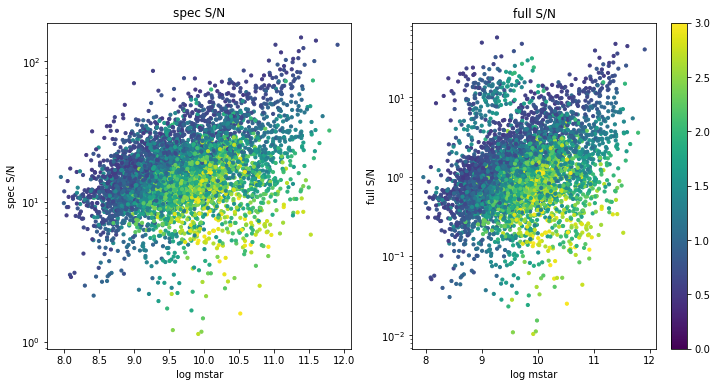

In [134]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(cat['logmass'][:5000], outsnr['spec_snr'][:5000], c=cat['z'][:5000], vmin=0, vmax=3, s=10)
plt.scatter(cat['logmass'][:5000], outsnr['full_snr'][:5000], c=cat['z'][:5000], vmin=0, vmax=3, s=10 )
ax1.set_title('spec S/N')
ax2.set_title('full S/N')
plt.colorbar()
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylabel('spec S/N')
ax2.set_ylabel('full S/N')
ax1.set_xlabel('log mstar')
ax2.set_xlabel('log mstar')

mean full s/n=12.83
mean spec s/n=67.18


Text(0.5, 1.0, 'object 21')

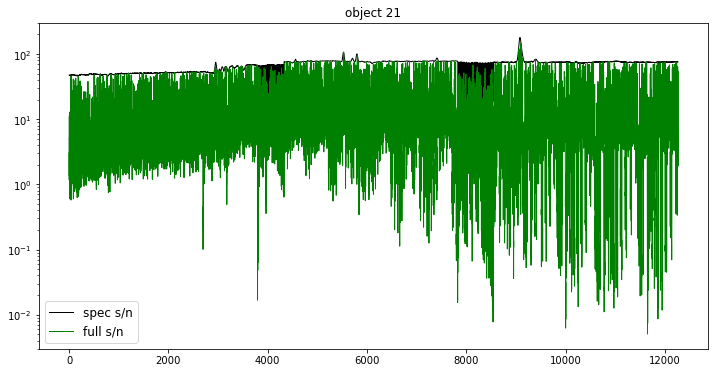

In [103]:
fig = plt.subplots(1, 1, figsize=(12, 6))
plt.plot(spec_snr, 'k-', lw=1, label = 'spec s/n')
plt.plot(full_snr, 'g-', lw=1, label = 'full s/n')
print('mean full s/n=%.2f' %np.nanmean(full_snr))
print('mean spec s/n=%.2f' %np.nanmean(spec_snr))
plt.yscale('log')
plt.legend(loc=3, fontsize=12)
plt.title('object 21')

# check the results

In [67]:
noisy_mock = pickle.load(open('mockspec_noise.pickle', 'rb'))
print(len(noisy_mock))

63


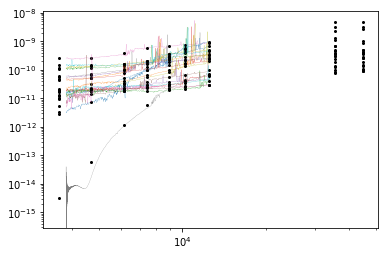

In [72]:
for i in range(20):
    obs = noisy_mock[i]
    smask = obs['mask']
    plt.plot(obs['wavelength'][smask],obs['spectrum'][smask],'-',lw=0.2)
    plt.plot(obs['wave_effective'],obs['maggies'],'o',color='black',ms=2)

    #plt.ylim(obs['spectrum'].min()*0.5,obs['spectrum'].max()*2)
    #plt.xlim(obs['wavelength'][smask].min()*0.9,obs['wavelength'][smask].max()*1.1)
    
plt.xscale('log')
plt.yscale('log')

In [51]:
noisy_mock[0]['spectrum'], noisy_mock[1]['spectrum']

(array([3.42353007e-11, 3.32980543e-11, 3.23608080e-11, ...,
        8.16901749e-11, 8.16010317e-11, 8.15118884e-11]),
 array([3.42353007e-11, 3.32980543e-11, 3.23608080e-11, ...,
        8.16901749e-11, 8.16010317e-11, 8.15118884e-11]))

In [7]:
theta_all_df = pd.read_csv('theta_all.csv')  
theta_all_df.head()

Unnamed: 0    zred   logzsol     dust2    logmass  logsfr_ratios_1  \
0           0  1.3049 -0.002319  1.301110  10.839858         0.287527   
1           1  1.7499 -0.525631  1.452828  10.749336         0.130268   
2           2  1.0761 -0.316589  0.256805   9.707042         0.141272   
3           3  1.6570  0.005855  0.060701   9.535103         0.039986   
4           4  0.9595  0.175355  0.457924   8.991671         0.478305   

   logsfr_ratios_2  logsfr_ratios_3  logsfr_ratios_4  logsfr_ratios_5  \
0         0.360746         0.007887         0.094987        -0.397966   
1         0.021570         0.103364         0.134724         0.170473   
2        -0.079488         0.232298         0.246719        -0.046887   
3        -0.027774         0.075973         0.054073        -0.277874   
4         0.024281         0.087817         0.120713        -0.222503   

   logsfr_ratios_6       afe  dust_index  dust1_fraction  sigma_smooth  \
0         0.171088  0.392304   -0.251204        1.242748    175.131824   
1         0.020996  0.455638    0.064709        1.183590    162.800750   
2        -0.113470  0.385323    0.146460        1.216480     80.905463   
3        -0.326199  0.409724   -0.720550        0.855360     69.543155   
4        -0.114064  0.448103    0.355901        0.827080     38.185095   

   gas_logz  gas_logu  eline_sigma  
0 -0.002319      -2.0   175.131824  
1 -0.525631      -2.0   162.800750  
2 -0.316589      -2.0    80.905463  
3  0.005855      -2.0    69.543155  
4  0.175355      -2.0    38.185095

# load parameter file

In [6]:
cat=pickle.load(open('../input/prospector_3dhst_bestfit_catalog.pickle', 'rb'))
for ikey in cat.keys():
    print(ikey, cat[ikey][:5])

dust1_fraction [1.24274787 1.18358962 1.21648014 0.85535957 0.82708048]
dust2 [1.30110954 1.45282801 0.25680514 0.06070061 0.45792446]
dust_index [-0.25120421  0.06470886  0.14646028 -0.72055     0.35590058]
gas_logz [ 0.11262719 -0.16669341 -0.67486781  0.2276225  -1.01314053]
logsfr_ratios_1 [0.28752652 0.13026776 0.14127212 0.03998617 0.47830477]
logsfr_ratios_2 [ 0.36074601  0.02157012 -0.07948795 -0.02777394  0.02428069]
logsfr_ratios_3 [0.00788727 0.10336385 0.23229781 0.07597261 0.08781713]
logsfr_ratios_4 [0.09498663 0.13472415 0.24671893 0.05407279 0.12071265]
logsfr_ratios_5 [-0.39796617  0.17047266 -0.04688681 -0.27787392 -0.22250321]
logsfr_ratios_6 [ 0.17108806  0.02099638 -0.11346972 -0.3261988  -0.11406414]
z [1.3049 1.7499 1.0761 1.657  0.9595]
name ['AEGIS_13' 'AEGIS_17' 'AEGIS_19' 'AEGIS_22' 'AEGIS_23']
log_stellarmass [10.66677611 10.55743587  9.51026845  9.28363582  8.38584093]
log_ssfr [5.91985838e-10 9.85640418e-10 6.02756909e-10 7.42222202e-10
 1.06572010e-09]
lo

In [97]:
index = np.argwhere(np.logical_and(cat['logmass']>10, cat['z']<0.55))
print(index)

[[  270]
 [  855]
 [  929]
 [ 1139]
 [ 1150]
 [ 1206]
 [ 1522]
 [ 1546]
 [ 1596]
 [ 1946]
 [ 2041]
 [ 2189]
 [ 2209]
 [ 2266]
 [ 2608]
 [ 2618]
 [ 2669]
 [ 3290]
 [ 3347]
 [ 3504]
 [ 3777]
 [ 4356]
 [ 4579]
 [ 4636]
 [ 4744]
 [ 4979]
 [ 5088]
 [ 5308]
 [ 5512]
 [ 5576]
 [ 6358]
 [ 6413]
 [ 6746]
 [ 6819]
 [ 6824]
 [ 7249]
 [ 7759]
 [ 8073]
 [ 8290]
 [ 8450]
 [ 8818]
 [ 9884]
 [ 9948]
 [10180]
 [11805]
 [12177]
 [12833]
 [13101]
 [13137]
 [13513]
 [13635]
 [13644]
 [14727]
 [14797]
 [15982]
 [16808]
 [16942]
 [16975]
 [17017]
 [17658]
 [18018]
 [18246]
 [18596]
 [18629]
 [18658]
 [18669]
 [18682]
 [18706]
 [18809]
 [18847]
 [20294]
 [20586]
 [20739]
 [21308]
 [21412]
 [21423]
 [21427]
 [21499]
 [21637]
 [21803]
 [22128]
 [22199]
 [22420]
 [22798]
 [22830]
 [22916]
 [22971]
 [23017]
 [23179]
 [23272]
 [23629]
 [23689]
 [23777]
 [23855]
 [23876]
 [24018]
 [24125]
 [24254]
 [24277]
 [24282]
 [24319]
 [24406]
 [24561]
 [24645]
 [24657]
 [24879]
 [25034]
 [25157]
 [25452]
 [25804]
 [25904]
 